In [1]:
import sys
sys.path.append('..')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Objective
In this notebook, we will show how to evaluate the performance of a model on a test or validation set. 
This notebook assumes that the network has already been trained and saved.

# Input
1. data_dir: directory of the data. The datafile should be present in the data_dir.
2. ckpt_dir: directory of the checkpoint. The checkpoint file and config should be present in the ckpt_dir.

In [3]:
import random
import os
import numpy as np
import torch
import pickle
import ml_collections
import glob
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from tqdm import tqdm
import numpy as np
from usplit.training import create_dataset, create_model
import matplotlib.pyplot as plt
from usplit.core.loss_type import LossType
from usplit.config_utils import load_config
from usplit.analysis.lvae_utils import get_img_from_forward_output
from usplit.analysis.plot_utils import clean_ax
from usplit.core.data_type import DataType
from usplit.core.psnr import PSNR
from usplit.analysis.plot_utils import get_k_largest_indices,plot_imgs_from_idx
from usplit.core.psnr import PSNR, RangeInvariantPsnr
from usplit.core.data_split_type import DataSplitType
from usplit.analysis.stitch_prediction import stitch_predictions
from usplit.analysis.mmse_prediction import get_dset_predictions


torch.multiprocessing.set_sharing_strategy('file_system')

In [4]:
# data_dir = '/group/jug/ashesh/data/ventura_gigascience/'
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2502/D7-M3-S0-L0/2'
# ckpt_dir = "/home/ashesh.ashesh/paper_models/Hagen/MitoVsAct/LeanLC/"

# ckpt_dir = '/group/jug/ashesh/training/disentangle/2502/D7-M3-S0-L0/8'
# data_dir = '/group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/'
# ckpt_dir = '/group/jug/ashesh/training_pre_eccv/disentangle/2211/D7-M3-S0-L0/1'
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2410/D7-M3-S0-L0/4'

ckpt_dir = '/group/jug/ashesh/training/disentangle/2502/D12-M3-S0-L0/2'
data_dir = '/group/jug/ashesh/data/diffsplit_HT_T24/'
mmse_count = 1
image_size_for_grid_centers = 32
custom_image_size = 64

MIXING_WEIGHT = 0.5
MAX_VAL = 1993 # This is just for HAGEN dataset !!! 

batch_size = 32
num_workers = 4
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test
val_repeat_factor = None

In [5]:
def get_best_checkpoint(ckpt_dir):
    output = []
    for filename in glob.glob(ckpt_dir + "/*_best.ckpt"):
        output.append(filename)
    assert len(output) == 1, '\n'.join(output)
    return output[0]

In [6]:
from usplit.core.model_type import ModelType
config = load_config(ckpt_dir)
config = ml_collections.ConfigDict(config)
old_image_size = None
with config.unlocked():
    if 'test_fraction' not in config.training:
        config.training.test_fraction =0.0
        
    if 'datadir' not in config:
        config.datadir = ''
    if 'encoder' not in config.model:
        config.model.encoder = ml_collections.ConfigDict()
        assert 'decoder' not in config.model
        config.model.decoder = ml_collections.ConfigDict()
    
        config.model.encoder.dropout = config.model.dropout
        config.model.decoder.dropout = config.model.dropout
        config.model.encoder.blocks_per_layer = config.model.blocks_per_layer
        config.model.decoder.blocks_per_layer = config.model.blocks_per_layer
        config.model.encoder.n_filters = config.model.n_filters
        config.model.decoder.n_filters = config.model.n_filters
        
    if 'multiscale_retain_spatial_dims' not in config.model.decoder:
        config.model.decoder.multiscale_retain_spatial_dims = False
        
    if 'res_block_kernel' not in config.model.encoder:
        config.model.encoder.res_block_kernel = 3
        assert 'res_block_kernel' not in config.model.decoder
        config.model.decoder.res_block_kernel = 3
    
    if 'res_block_skip_padding' not in config.model.encoder:
        config.model.encoder.res_block_skip_padding = False
        assert 'res_block_skip_padding' not in config.model.decoder
        config.model.decoder.res_block_skip_padding = False
    
    if config.data.data_type == DataType.CustomSinosoid:
        if 'max_vshift_factor' not in config.data:
            config.data.max_vshift_factor = config.data.max_shift_factor
            config.data.max_hshift_factor = 0
        if 'encourage_non_overlap_single_channel' not in config.data:
            config.data.encourage_non_overlap_single_channel = False
            
    if 'skip_bottom_layers_count' in config.model:
        config.model.skip_bottom_layers_count = 0
        
    if 'logvar_lowerbound' not in config.model:
        config.model.logvar_lowerbound = None
    if 'train_aug_rotate' not in config.data:
        config.data.train_aug_rotate = False
    if 'multiscale_lowres_separate_branch' not in config.model:
        config.model.multiscale_lowres_separate_branch = False
    if 'multiscale_retain_spatial_dims' not in config.model:
        config.model.multiscale_retain_spatial_dims = False
    config.data.train_aug_rotate=False
    
    if 'randomized_channels' not in config.data:
        config.data.randomized_channels = False
        
    if 'predict_logvar' not in config.model:
        config.model.predict_logvar=None
    
    if 'batchnorm' in config.model and 'batchnorm' not in config.model.encoder:
        assert 'batchnorm' not in config.model.decoder
        config.model.decoder.batchnorm = config.model.batchnorm
        config.model.encoder.batchnorm = config.model.batchnorm
    if 'conv2d_bias' not in config.model.decoder:
        config.model.decoder.conv2d_bias = True
        
    
    if custom_image_size is not None:
        old_image_size = config.data.image_size
        config.data.image_size = custom_image_size
    if image_size_for_grid_centers is not None:
        old_grid_size = config.data.get('grid_size', "grid_size not present")
        config.data.grid_size = image_size_for_grid_centers
        config.data.val_grid_size = image_size_for_grid_centers

    if use_deterministic_grid is not None:
        config.data.deterministic_grid = use_deterministic_grid
    if threshold is not None:
        config.data.threshold = threshold
    if val_repeat_factor is not None:
        config.training.val_repeat_factor = val_repeat_factor
    config.model.mode_pred = not compute_kl_loss

    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0
print(config)

data:
  channelwise_quantile: false
  clip_percentile: 1.0
  data_type: 12
  deterministic_grid: false
  enable_poisson_noise: false
  grid_size: 32
  image_size: 64
  multiscale_lowres_count: 5
  normalized_input: true
  padding_mode: reflect
  padding_value: null
  randomized_channels: false
  sampler_type: 0
  target_separate_normalization: true
  threshold: 0.0
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 32
datadir: /group/jug/ashesh/data/diffsplit_HT_T24/
exptname: 2502/D12-M3-S0-L0/2
git:
  branch: indi_baseline
  changedFiles:
  - examples/EvaluateWithDifferentMixingWeights.ipynb
  latest_commit: 460cff372d0e7cb034a5ce00f0467cdefc49ba40
  untracked_files:
  - examples/EvaluateRealInput.ipynb
hostname: lin-jug-m-03
loss:
  free_bits: 0.0
  kl_annealing: false
  kl_annealtime: 10
  kl_min: 1.0e-07
  kl_start: -1
  kl_weight: 1
  loss_type: 0
  skip_receptive_field_loss_tokens: []
model:
  analytical_kl: false
  decoder:
    batchnorm: true
    blocks_per_laye

In [7]:
# since we are doing the clipping in the other way.
config.data.clip_percentile = 1

## Loading the dataset

In [8]:
from usplit.data_loader.multi_channel_determ_tiff_dloader import MultiChDeterministicTiffDloader
from usplit.data_loader.lc_tiff_dloader import MultiScaleTiffDloader
from usplit.core.data_split_type import DataSplitType
from usplit.data_loader.patch_index_manager import TilingMode

class TiffDloaderMixed(MultiChDeterministicTiffDloader):
    """
    Now, we have just the inputs, and no targets. 
    """
    def load_data(self, data_config, datasplit_type, val_fraction=None, test_fraction=None, allow_generation=None,test_img_arr=None):
        super().load_data(data_config, datasplit_type, val_fraction=val_fraction, test_fraction=test_fraction, allow_generation=allow_generation,test_img_arr=test_img_arr)
        self._data_original = self._data
        new_data = self._data.copy()
        if config.data.data_type == DataType.SeparateTiffData:
            print('Clipping the data to 1993')
            new_data[new_data > MAX_VAL] = MAX_VAL

        self._data = new_data[...,0:1] * MIXING_WEIGHT + new_data[...,1:2] * (1-MIXING_WEIGHT)
        self._data = np.repeat(self._data, 2, axis=-1)
        # self._data[self._data > MAX_VAL] = MAX_VAL

class MultiScaleTiffDloaderMixed(MultiScaleTiffDloader):
    """
    Now, we have just the inputs, and no targets. 
    """
    def load_data(self, data_config, datasplit_type, val_fraction=None, test_fraction=None, allow_generation=None,test_img_arr=None):
        super().load_data(data_config, datasplit_type, val_fraction=val_fraction, test_fraction=test_fraction, allow_generation=allow_generation,test_img_arr=test_img_arr)
        self._data_original = self._data
        new_data = self._data.copy()
        if config.data.data_type == DataType.SeparateTiffData:
            print('Clipping the data to 1993')
            new_data[new_data > MAX_VAL] = MAX_VAL

        self._data = new_data[...,0:1] * MIXING_WEIGHT + new_data[...,1:2] * (1-MIXING_WEIGHT)
        self._data = np.repeat(self._data, 2, axis=-1)
        # self._data[self._data > MAX_VAL] = MAX_VAL

padding_kwargs = {
    'mode':config.data.get('padding_mode','constant'),
}

if padding_kwargs['mode'] == 'constant':
    padding_kwargs['constant_values'] = config.data.get('padding_value',0)

dloader_kwargs = {'overlapping_padding_kwargs':padding_kwargs}
if 'multiscale_lowres_count' in config.data and config.data.multiscale_lowres_count is not None:
    data_class = MultiScaleTiffDloaderMixed
    dloader_kwargs['num_scales'] = config.data.multiscale_lowres_count
    dloader_kwargs['padding_kwargs'] = padding_kwargs
else:
    # raise Exception('Not implemented')
    data_class = TiffDloaderMixed

if config.data.data_type in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve, 
                             DataType.SeparateTiffData, DataType.HTLIF24, DataType.HTT24
                            ]:
    datapath = data_dir
elif config.data.data_type == DataType.OptiMEM100_014:
    datapath = os.path.join(data_dir, 'OptiMEM100x014.tif')
else:
    raise NotImplementedError(config.data.data_type)

normalized_input = config.data.normalized_input
use_one_mu_std = config.data.use_one_mu_std
train_aug_rotate = config.data.train_aug_rotate
enable_random_cropping = False
grid_alignment = TilingMode.ShiftBoundary
print(data_class)

train_dset = data_class(
                config.data,
                datapath,
                datasplit_type=DataSplitType.Train,
                val_fraction=config.training.val_fraction,
                test_fraction=config.training.test_fraction,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=train_aug_rotate,
                enable_random_cropping=enable_random_cropping,
                grid_alignment=grid_alignment,
                **dloader_kwargs)
import gc
gc.collect()
max_val = train_dset.get_max_val()

val_dset = data_class(
                config.data,
                datapath,
                datasplit_type=eval_datasplit_type,
                val_fraction=config.training.val_fraction,
                test_fraction=config.training.test_fraction,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=False,  # No rotation aug on validation
                enable_random_cropping=False,
                # No random cropping on validation. Validation is evaluated on determistic grids
                grid_alignment=grid_alignment,
                max_val=max_val,
                **dloader_kwargs
                
            )

# For normalizing, we should be using the training data's mean and std.
mean_val, std_val = train_dset.compute_mean_std()
train_dset.set_mean_std(mean_val, std_val)
val_dset.set_mean_std(mean_val, std_val)


if evaluate_train:
    val_dset = train_dset
data_mean, data_std = train_dset.get_mean_std()


<class '__main__.MultiScaleTiffDloaderMixed'>
Loaded HTT24 data from /group/jug/ashesh/data/diffsplit_HT_T24/train/train.tif (292, 1608, 1608, 2)
[MultiScaleTiffDloaderMixed] Sz:64 Train:1 N:292 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:1.0 SummedInput:False ReplaceWithRandSample:False BckQ:0.0 Pad:{'mode': 'reflect'}
Loaded HTT24 data from /group/jug/ashesh/data/diffsplit_HT_T24/test/test.tif (36, 1608, 1608, 2)
[MultiScaleTiffDloaderMixed] Sz:64 Train:0 N:36 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:1.0 SummedInput:False ReplaceWithRandSample:False BckQ:0.0 Pad:{'mode': 'reflect'}


In [9]:
val_dset._data.max(), train_dset._data.max()

(5167.0, 5167.0)

## Loading the model

In [10]:
with config.unlocked():
    if old_image_size is not None:
        config.data.image_size = old_image_size

if config.data.target_separate_normalization is True:
    mean_fr_model, std_fr_model = train_dset.compute_individual_mean_std()
else:
    mean_fr_model, std_fr_model = train_dset.get_mean_std()


model = create_model(config, mean_fr_model,std_fr_model)

ckpt_fpath = get_best_checkpoint(ckpt_dir)
checkpoint = torch.load(ckpt_fpath)

_ = model.load_state_dict(checkpoint['state_dict'])
model.eval()
_= model.cuda()

model.set_params_to_same_device_as(torch.Tensor(1).cuda())

print('Loading from epoch', checkpoint['epoch'])

[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:0 McFactor2
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:0 McFactor4
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:0 McFactor8
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:0 McFactor16
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5
[LadderVAE] Enc [ResKSize3 SkipPadding:False]  Dec [ResKSize3 SkipPadding:False] Stoc:True
Loading from epoch 149


In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model has {count_parameters(model)/1000_000:.3f}M parameters')

Model has 3.658M parameters


In [12]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

## Mean/Std as present in usplit. Just run Evaluate.ipynb for this config and set it here

In [13]:
if config.data.data_type == DataType.SeparateTiffData:
    mean_val_usplit = np.array([[[[237.37582]],[[237.37582]]]])
    std_val_usplit = np.array([[[[299.02316]],[[299.02316]]]])
elif config.data.data_type in [DataType.HTLIF24, DataType.HTT24]:
    mean_val_usplit, std_val_usplit = train_dset.get_mean_std()
else:
    raise NotImplementedError(config.data.data_type)
val_dset.set_mean_std(mean_val_usplit, std_val_usplit)

## Looking at the input

Text(0, 0.5, 'Target')

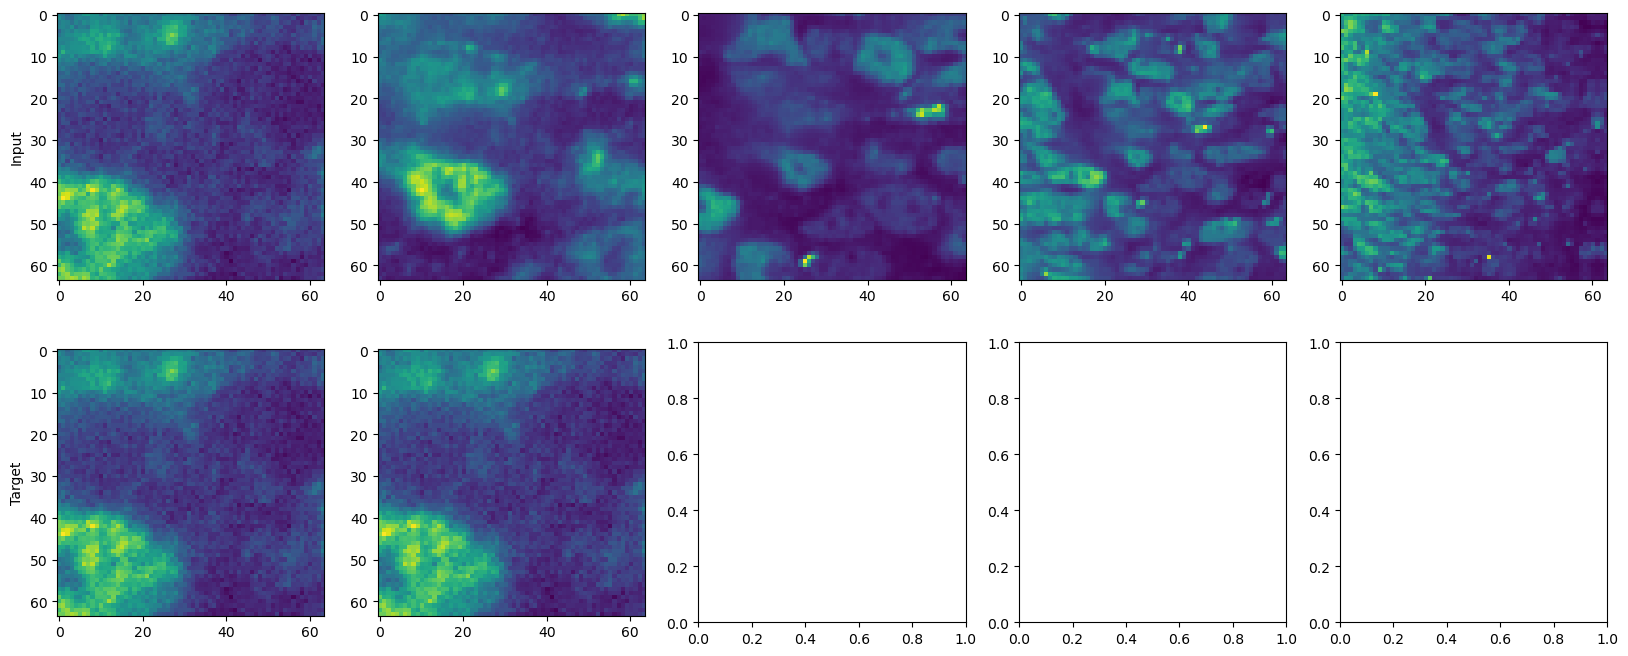

In [14]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
if inp_tmp.ndim == 2:
    inp_tmp = inp_tmp[None,...]

ncols = max(len(inp_tmp),3)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(len(inp_tmp)):
    ax[0,i].imshow(inp_tmp[i])


ax[1,0].imshow(tar_tmp[0])
ax[1,1].imshow(tar_tmp[1])

ax[0,0].set_ylabel('Input')
ax[1,0].set_ylabel('Target')

In [15]:
pred_tiled, rec_loss, logvar, patch_psnr_tuple = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))

  0%|          | 0/2813 [00:00<?, ?it/s]

100%|██████████| 2813/2813 [02:07<00:00, 22.11it/s]


Patch wise PSNR, as computed during training [23.98 23.98] 23.98


In [16]:
idx_list = np.where(logvar.squeeze() < -6)[0]
if len(idx_list) > 0:
    plt.imshow(val_dset[idx_list[0]][1][1])

In [17]:
pred = stitch_predictions(pred_tiled,val_dset)

In [18]:
def print_ignored_pixels():
    ignored_pixels = 1
    while(pred[0,-ignored_pixels:,-ignored_pixels:,].std() ==0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

ignored_pixels_in_data = print_ignored_pixels()

In (36, 1608, 1608, 2), last 0 many rows and columns are all zero.


## Ignore the pixels which are present in the last few rows and columns. 
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now.

In [19]:
ignored_pixels_in_data

0

In [20]:
ignore_last_pixels_count = 32 if config.data.data_type == DataType.OptiMEM100_014 else ignored_pixels_in_data

assert ignored_pixels_in_data <= ignore_last_pixels_count, f'Set ignore_last_pixels_count={ignored_pixels_in_data}'
print(ignore_last_pixels_count)

0


In [21]:
tar = val_dset._data_original
if config.data.data_type == DataType.SeparateTiffData:
    tar[ tar > MAX_VAL] = MAX_VAL

def ignore_pixels(arr):
    if ignore_last_pixels_count:
        arr = arr[:,:-ignore_last_pixels_count,:-ignore_last_pixels_count]
    return arr

pred = ignore_pixels(pred)
tar = ignore_pixels(tar)


In [22]:
from skimage.metrics import structural_similarity

def _avg_psnr(target, prediction, psnr_fn):
    output = np.mean([psnr_fn(target[i:i + 1], prediction[i:i + 1]).item() for i in range(len(prediction))])
    return round(output, 2)


def avg_range_inv_psnr(target, prediction):
    return _avg_psnr(target, prediction, RangeInvariantPsnr)


def avg_psnr(target, prediction):
    return _avg_psnr(target, prediction, PSNR)


def compute_masked_psnr(mask, tar1, tar2, pred1, pred2):
    mask = mask.astype(bool)
    mask = mask[..., 0]
    tmp_tar1 = tar1[mask].reshape((len(tar1), -1, 1))
    tmp_pred1 = pred1[mask].reshape((len(tar1), -1, 1))
    tmp_tar2 = tar2[mask].reshape((len(tar2), -1, 1))
    tmp_pred2 = pred2[mask].reshape((len(tar2), -1, 1))
    psnr1 = avg_range_inv_psnr(tmp_tar1, tmp_pred1)
    psnr2 = avg_range_inv_psnr(tmp_tar2, tmp_pred2)
    return psnr1, psnr2

def avg_ssim(target, prediction):
    ssim = [structural_similarity(target[i],prediction[i], data_range=(target[i].max() - target[i].min())) for i in range(len(target))]
    return np.mean(ssim),np.std(ssim)

In [23]:
sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean['target']
    sep_std = sep_std['target']
    
sep_mean = sep_mean.squeeze()[None,None,None]
sep_std = sep_std.squeeze()[None,None,None]

tar_normalized = (tar - sep_mean.cpu().numpy())/sep_std.cpu().numpy()
tar1 =tar_normalized[...,0]
tar2 =tar_normalized[...,1]

7


(36, 1608, 1608, 2)

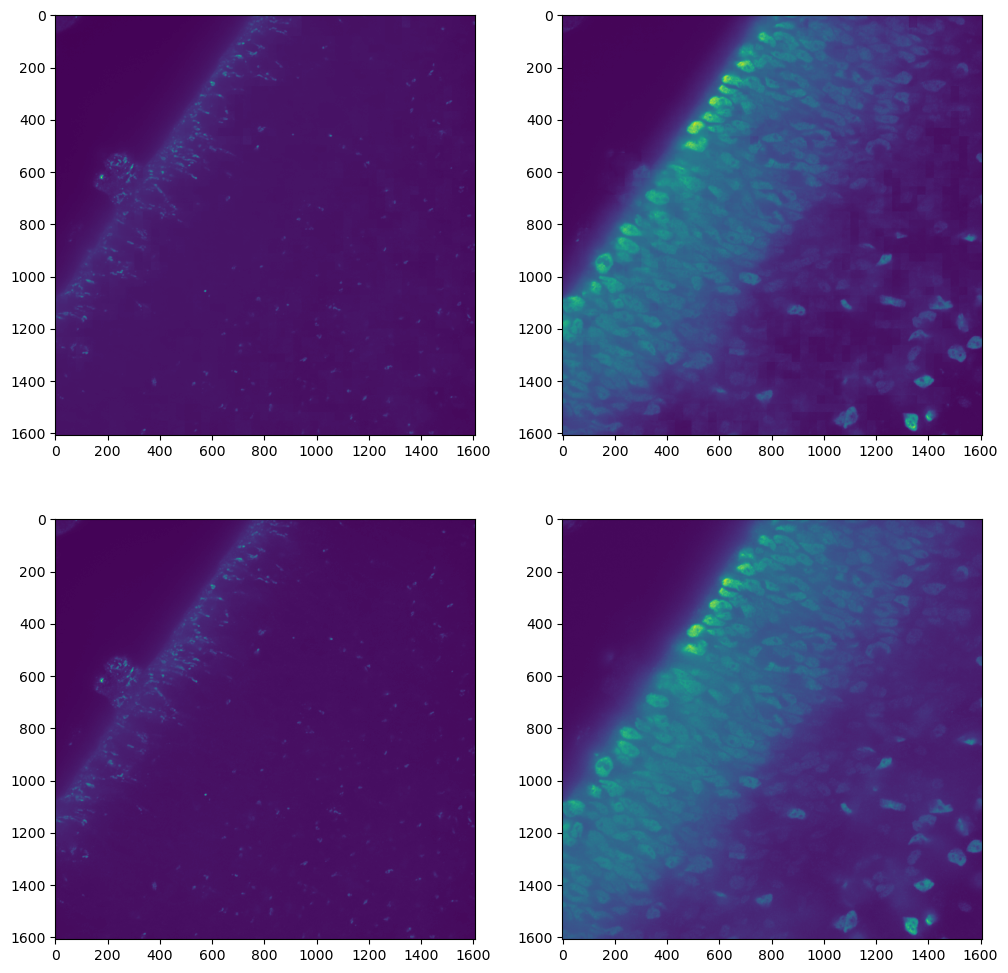

In [24]:
_,ax = plt.subplots(figsize=(12,12),ncols=2,nrows=2)
idx = np.random.randint(len(pred))
print(idx)
ax[0,0].imshow(pred[idx,:,:,0])
ax[0,1].imshow(pred[idx,:,:,1])
ax[1,0].imshow(tar1[idx,:,:])
ax[1,1].imshow(tar2[idx,:,:])

pred.shape

In [25]:
pred1, pred2 = pred[...,0].astype(np.float32), pred[...,1].astype(np.float32)
rmse1 =np.sqrt(((pred1 - tar1)**2).reshape(len(pred1),-1).mean(axis=1))
rmse2 =np.sqrt(((pred2 - tar2)**2).reshape(len(pred2),-1).mean(axis=1)) 

rmse = (rmse1 + rmse2)/2
rmse = np.round(rmse,3)
psnr1 = avg_psnr(tar1, pred1) 
psnr2 = avg_psnr(tar2, pred2)
rinv_psnr1 = avg_range_inv_psnr(tar1, pred1)
rinv_psnr2 = avg_range_inv_psnr(tar2, pred2)
ssim1_mean, ssim1_std = avg_ssim(tar1, pred1)
ssim2_mean, ssim2_std = avg_ssim(tar2, pred2)

In [26]:
print(f'W:{MIXING_WEIGHT} {DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignore_last_pixels_count}')
print('Rec Loss',np.round(rec_loss.mean(),3) )
print('RMSE', np.mean(rmse1).round(3), np.mean(rmse2).round(3), np.mean(rmse).round(3))
print('[Paper] RangeInv PSNR',rinv_psnr1, rinv_psnr2 )
print('[Paper] SSIM',round(ssim1_mean,3), round(ssim2_mean,3),'±',round((ssim1_std + ssim2_std)/2,4))
print()

W:0.5 Test_P64_G32_M1_Sk0
Rec Loss 2953104.5
RMSE 0.464 0.359 0.412
[Paper] RangeInv PSNR 40.53 33.36
[Paper] SSIM 0.698 0.711 ± 0.093



In [27]:
print(sep_mean.shape, sep_std.shape)
pred_unnormalized = pred * sep_std.cpu().numpy() + sep_mean.cpu().numpy()


torch.Size([1, 1, 1, 2]) torch.Size([1, 1, 1, 2])


In [28]:
pred_unnormalized.shape

(36, 1608, 1608, 2)

In [29]:
from usplit.core.metrics import compute_stats
stats_dict = compute_stats(tar, pred_unnormalized)
print(f'W:{MIXING_WEIGHT} {DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignore_last_pixels_count}')
print(ckpt_dir)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 36/36 [00:04<00:00,  8.18it/s]


KeyboardInterrupt: 

In [31]:
param_str = f"T-{MIXING_WEIGHT}_MMSE-{mmse_count}"
ckpt_str = 'uSplit_' + '_'.join(ckpt_dir.split('/')[-3:])
result_dir = os.path.join('/group/jug/ashesh/indiSplit/', 'prediction_baselines',ckpt_str + '_' + param_str)
os.makedirs(result_dir, exist_ok=True)
print(result_dir)

/group/jug/ashesh/indiSplit/prediction_baselines/uSplit_MitoVsAct_LeanLC__T-0.5_MMSE-1


In [31]:
from skimage.io import imread, imsave
def save_tiff(path, data):
    imsave(path, data, plugin='tifffile')


save_tiff(os.path.join(result_dir,'pred.tif'), pred_unnormalized)
# save_tiff(os.path.join(result_dir,'dim_pred.tif'), pred_dim_pred_stitched)
# pred_bt_removed_stitched.shape, pred_bt_removed_stitched.shape

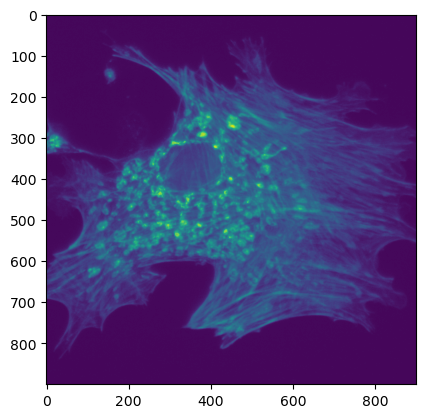

In [32]:
plt.imshow(tar1[0,1100:2000,900:1800] + tar2[0,1100:2000,900:1800])